# 🎭 Complete Emotion Recognition Pipeline

This notebook provides a comprehensive pipeline for emotion recognition from speech using multiple machine learning approaches:
- **MLP (Multi-Layer Perceptron)** - Deep Learning approach
- **SVM (Support Vector Machine)** - Traditional ML approach
- **KNN (K-Nearest Neighbors)** - Instance-based learning approach

## 📋 Pipeline Overview
1. **Data Loading & Exploration**
2. **Audio Preprocessing**
3. **Feature Extraction (MFCC)**
4. **Data Splitting & Preprocessing**
5. **Model Training & Evaluation**
6. **Performance Comparison**
7. **Prediction on New Audio Files**


## 🚀 Setup and GPU Optimization


In [8]:
# 🚀 GPU Optimization Setup
import tensorflow as tf
import numpy as np
import pynvml
import warnings
import os
warnings.filterwarnings('ignore')

# Set environment variables for better GPU memory management
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

def setup_gpu_environment():
    """Setup GPU environment with optimal settings."""
    print("🔧 Setting up GPU environment...")
    
    # Check GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        print("❌ No GPUs found - using CPU")
        return False
    
    print(f"✓ Found {len(gpus)} GPU(s)")
    
    # Configure GPU memory growth
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ GPU memory growth enabled")
    except Exception as e:
        print(f"⚠️  Could not set memory growth: {e}")
    
    # Enable mixed precision for better performance
    try:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("✓ Mixed precision enabled (FP16)")
    except Exception as e:
        print(f"⚠️  Could not enable mixed precision: {e}")
    
    return True

def get_gpu_info():
    """Get detailed GPU information."""
    try:
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        
        info = {
            'name': pynvml.nvmlDeviceGetName(handle).decode(),
            'memory_total': pynvml.nvmlDeviceGetMemoryInfo(handle).total / 1024**3,
            'memory_used': pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**3,
            'memory_free': pynvml.nvmlDeviceGetMemoryInfo(handle).free / 1024**3,
            'temperature': pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU),
            'power_usage': pynvml.nvmlDeviceGetPowerUsage(handle) / 1000
        }
        
        return info
    except Exception as e:
        print(f"Error getting GPU info: {e}")
        return None

def print_gpu_info():
    """Print GPU information in a formatted way."""
    info = get_gpu_info()
    if not info:
        return
    
    print("\n💾 GPU Information")
    print("=" * 50)
    print(f"GPU Name: {info['name']}")
    print(f"Total Memory: {info['memory_total']:.2f} GB")
    print(f"Used Memory:  {info['memory_used']:.2f} GB")
    print(f"Free Memory:   {info['memory_free']:.2f} GB")
    print(f"Usage:         {info['memory_used']/info['memory_total']*100:.1f}%")
    print(f"Temperature:   {info['temperature']}°C")
    print(f"Power Usage:   {info['power_usage']:.1f} W")

def gpu_device():
    """Context manager for GPU operations."""
    return tf.device('/GPU:0')

# Setup GPU environment
print("🔧 Setting up GPU environment for emotion recognition...")
setup_gpu_environment()

# Display GPU information
print_gpu_info()

print("✅ GPU environment ready for accelerated processing!")


🔧 Setting up GPU environment for emotion recognition...
🔧 Setting up GPU environment...
✓ Found 1 GPU(s)
✓ GPU memory growth enabled
✓ Mixed precision enabled (FP16)

💾 GPU Information
GPU Name: NVIDIA GeForce RTX 2060
Total Memory: 6.00 GB
Used Memory:  0.43 GB
Free Memory:   5.57 GB
Usage:         7.2%
Temperature:   30°C
Power Usage:   7.7 W
✅ GPU environment ready for accelerated processing!


## 📦 Import Libraries


In [10]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile as wavfile
import scipy.fftpack as fourier
import scipy.signal as sg
import math

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Utilities
from datetime import datetime
import time
import pickle
import joblib

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 📊 Data Loading and Exploration


In [11]:
# Load metadata for both datasets
print("📊 Loading dataset metadata...")

# EMODB dataset
emodb_metadata = pd.read_csv('metadatos/EMODB - testSize 0.3.csv')
print(f"EMODB dataset: {len(emodb_metadata)} samples")
print("EMODB classes:")
print(emodb_metadata['class_name'].value_counts())

print("\n" + "="*50 + "\n")

# EMOVO dataset
emovo_metadata = pd.read_csv('metadatos/emovo - testSize 0.3.csv')
print(f"EMOVO dataset: {len(emovo_metadata)} samples")
print("EMOVO classes:")
print(emovo_metadata['class_name'].value_counts())

# Combine datasets
emodb_metadata['dataset'] = 'EMODB'
emovo_metadata['dataset'] = 'EMOVO'

# Create unified dataset
combined_metadata = pd.concat([emodb_metadata, emovo_metadata], ignore_index=True)
print(f"\n📈 Combined dataset: {len(combined_metadata)} total samples")
print("Combined class distribution:")
print(combined_metadata['class_name'].value_counts())


📊 Loading dataset metadata...
EMODB dataset: 535 samples
EMODB classes:
class_name
W ira             127
L aburrimiento     81
N neutral          79
A angustia         73
F alegria          71
T tristeza         62
E disgusto         42
Name: count, dtype: int64


EMOVO dataset: 588 samples
EMOVO classes:
class_name
A angustia    84
E disgusto    84
L Sorpresa    84
F alegria     84
N neutral     84
T tristeza    84
W ira         84
Name: count, dtype: int64

📈 Combined dataset: 1123 total samples
Combined class distribution:
class_name
W ira             211
N neutral         163
A angustia        157
F alegria         155
T tristeza        146
E disgusto        126
L Sorpresa         84
L aburrimiento     81
Name: count, dtype: int64


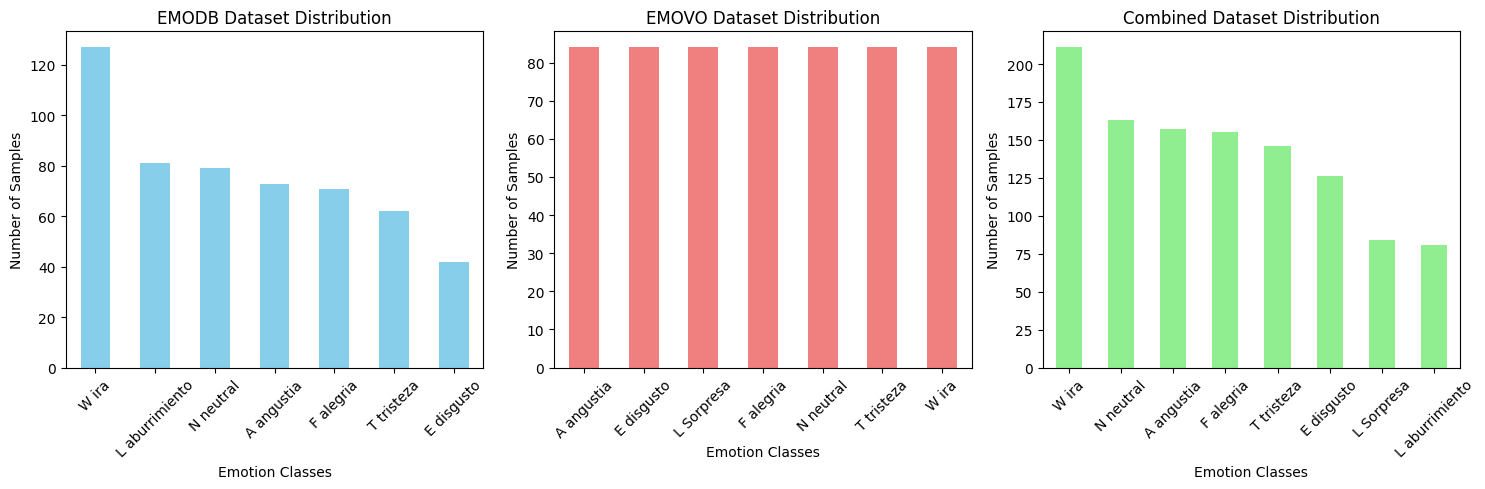

In [12]:
# Visualize class distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
emodb_metadata['class_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('EMODB Dataset Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
emovo_metadata['class_name'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('EMOVO Dataset Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
combined_metadata['class_name'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Combined Dataset Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 🎵 Audio Preprocessing and Feature Extraction


In [13]:
# Custom MFCC Feature Extraction Class
class MelFreqCepsCoef:
    def __init__(self, file_name, n_mfcc=40, frame_length=0.03, overlap=50, n_filters=22):
        """Initialize MFCC feature extraction with custom parameters."""
        # Load audio file
        self.fs, self.signal = wavfile.read(file_name)
        
        # Parameters
        self.f_max = self.fs / 2.0
        self.preemphasis = 0.0
        self.frame = frame_length
        self.overlap = overlap
        self.window = 2  # Hann window
        self.f_min = 0
        self.n_filters = n_filters
        self.n_mfcc = n_mfcc
        self.norm = 1
        self.rasta = 0
        
        # Process audio
        self.audio = self.signal / 32767
        self.audio_length = len(self.signal)
        self.frame_size = np.fix(self.frame * self.fs)
        self.overlap_size = np.fix(self.frame_size - self.frame_size * (self.overlap / 100.0))
        self.n_frames = self.__Frames()
        self.audio_avg = self.__Stereo()
        self.half_n = np.fix(self.frame_size / 2.0)
        self.window_data = self.__Window()
        self.freqs = self.__Freqs()
        self.mel_freqs = self.__Mel_Freqs()
        self.mel_filter_bank = self.__Mel_Filter()
        self.coef, self.nl = self.__MFCC_Coef()
        self.coef = self.coef[:, 0:self.nl]
        self.mfccsscalade = np.mean(self.coef.T, axis=0)
    
    def __Stereo(self):
        """Convert stereo to mono and apply preemphasis."""
        n_channel = len(np.shape(self.audio))
        if n_channel > 1:
            temp_1 = self.audio[:, 0]
            temp_2 = self.audio[:, 1]
            avg = (temp_1 + temp_2) / 2
        else:
            avg = self.audio
        
        if self.preemphasis != 0.0:
            Avg = np.zeros(len(avg))
            Avg[0] = avg[0]
            for n in range(1, len(avg)):
                Avg[n] = avg[n] - self.preemphasis * avg[n-1]
            return Avg
        else:
            return avg
    
    def __Frames(self):
        """Determine number of frames."""
        i = 0
        j = 0
        while j < self.audio_length:
            j = i * self.overlap_size + self.frame_size
            i = i + 1
        return i - 1
    
    def __Window(self):
        """Apply window function."""
        n = np.arange(-self.half_n, self.half_n)
        if len(n) != self.frame_size:
            n = np.arange(-self.half_n, self.half_n + 1)
        
        if self.window == 0:  # Box window
            W = np.ones(len(n))
        elif self.window == 1:  # Hamming window
            a, b = 0.53836, 0.46164
            W = np.array([a + b * math.cos((2 * math.pi * i) / (self.frame_size - 1.0)) for i in n])
        elif self.window == 2:  # Hann window
            a, b = 0.5, 0.5
            W = np.array([a + b * math.cos((2 * math.pi * i) / (self.frame_size - 1.0)) for i in n])
        return W
    
    def __Freqs(self):
        """Calculate frequencies in Hz."""
        n = np.arange(0, self.half_n)
        return np.array([(i * self.fs) / self.frame_size for i in n])
    
    def __Mel_Freqs(self):
        """Calculate Mel frequencies."""
        n = np.arange(0, self.half_n)
        return np.array([2595 * np.log10(self.freqs[int(i)] / 700 + 1) for i in n])
    
    def __Mel_Filter(self):
        """Generate triangular filter bank."""
        phi_min = 2595 * math.log10(self.f_min / 700 + 1)
        phi_max = 2595 * math.log10(self.f_max / 700 + 1)
        dphi = (phi_max - phi_min) / (self.n_filters + 1)
        fc = np.zeros(self.n_filters + 2)
        fc[0] = self.f_min
        for i in range(1, len(fc)):
            phic = (i - 1) * dphi
            fc[i-1] = 700 * (math.pow(10, (phic + phi_min) / 2595) - 1)
        fc[self.n_filters + 1] = self.f_max
        
        Hkm = np.zeros((int(self.half_n), self.n_filters))
        n = np.arange(0, self.half_n)
        for i in range(1, self.n_filters + 1):
            for k in n:
                kk = int(k)
                if self.freqs[kk] < fc[i-1]:
                    Hkm[kk, i-1] = 0
                elif (self.freqs[kk] >= fc[i-1]) and (self.freqs[kk] < fc[i]):
                    Hkm[kk, i-1] = (self.freqs[kk] - fc[i-1]) / (fc[i] - fc[i-1])
                elif (self.freqs[kk] >= fc[i]) and (self.freqs[kk] < fc[i+1]):
                    Hkm[kk, i-1] = (self.freqs[kk] - fc[i+1]) / (fc[i] - fc[i+1])
                elif self.freqs[kk] >= fc[i+1]:
                    Hkm[kk, i-1] = 0
        return Hkm
    
    def __MFCC_Coef(self):
        """Calculate MFCC coefficients."""
        frame = np.zeros(int(self.frame_size))
        self.energy = np.zeros((int(self.half_n), self.n_frames))
        self.cepstrum = np.zeros((self.n_filters, self.n_frames))
        Xm = np.zeros(self.n_filters)
        mfcc = np.zeros(self.n_mfcc)
        wi = np.zeros(2 * self.n_mfcc)
        MFCC = np.zeros((self.n_mfcc, self.n_frames))
        
        # Liftering weights
        for i in range(0, 2 * self.n_mfcc):
            wi[i] = 1 + self.n_mfcc * np.sin(math.pi * i / (2 * self.n_mfcc - 1))
        
        # RASTA filter coefficients
        numer = np.arange(-2, 3)
        numer = -numer / np.sum(numer * numer)
        denom = np.array([1, -0.98])
        
        l = 0
        for i in range(0, int(self.n_frames)):
            frame = self.audio_avg[i*int(self.overlap_size):i*int(self.overlap_size)+int(self.frame_size)]
            
            # Autocorrelation function
            acorr = np.correlate(frame, frame, mode='full')
            m = np.amax(acorr[20:len(acorr)])
            
            if m > 0.1:
                frame = frame * self.window_data
                P = np.abs(fourier.fft(frame))
                self.energy[:, l] = 10 * np.log10(P[0:int(self.half_n)])
                
                for j in range(0, self.n_filters):
                    Ps = P[0:int(self.half_n)] * self.mel_filter_bank[:, j]
                    if self.rasta == 1:
                        Ps = np.log(1 + Ps)
                        Ps = sg.lfilter(numer, denom, Ps)
                        Ps = np.exp(Ps) - 1
                    Xm[j] = np.log(np.sum(Ps))
                
                self.cepstrum[:, l] = Xm
                
                # DCT
                for j in range(1, self.n_mfcc + 1):
                    suma = 0
                    for k in range(1, self.n_filters + 1):
                        suma += Xm[k-1] * np.cos(math.pi * j * (k - 0.5) / self.n_filters)
                    mfcc[j-1] = suma
                
                mfcc = mfcc * wi[0:self.n_mfcc]
                MFCC[:, l] = mfcc
                l = l + 1
        
        # Normalize
        if self.norm == 1:
            MFCC = (MFCC - np.mean(MFCC)) / np.std(MFCC)
        
        return MFCC, l

print("✅ MFCC feature extraction class defined!")


✅ MFCC feature extraction class defined!


In [7]:
# Extract features from all audio files
def extract_features_from_dataset(metadata, data_path, dataset_name):
    """Extract MFCC features from all audio files in the dataset."""
    print(f"🎵 Extracting features from {dataset_name} dataset...")
    
    features = []
    labels = []
    file_names = []
    
    for index, row in metadata.iterrows():
        try:
            # Construct file path
            if dataset_name == 'EMODB':
                file_path = os.path.join(data_path, 'EMODB', row['slice_file_name'])
            else:  # EMOVO
                file_path = os.path.join(data_path, 'EMOVO', row['slice_file_name'])
            
            # Extract MFCC features
            mfcc_extractor = MelFreqCepsCoef(file_path)
            mfcc_features = mfcc_extractor.mfccsscalade
            
            # Validate features - check for NaN or Inf values
            if np.isnan(mfcc_features).any() or np.isinf(mfcc_features).any():
                print(f"⚠️  Invalid features detected in {row['slice_file_name']} - replacing with zeros")
                mfcc_features = np.nan_to_num(mfcc_features, nan=0.0, posinf=0.0, neginf=0.0)
            
            features.append(mfcc_features)
            labels.append(row['class_name'])
            file_names.append(row['slice_file_name'])
            
            if (index + 1) % 50 == 0:
                print(f"Processed {index + 1}/{len(metadata)} files...")
                
        except Exception as e:
            print(f"Error processing {row['slice_file_name']}: {e}")
            # Add zero features for failed extractions to maintain dataset size
            zero_features = np.zeros(40)  # Assuming 40 MFCC coefficients
            features.append(zero_features)
            labels.append(row['class_name'])
            file_names.append(row['slice_file_name'])
            continue
    
    print(f"✅ Feature extraction completed for {dataset_name}!")
    
    # Convert to numpy array and validate
    features_array = np.array(features)
    print(f"Features shape: {features_array.shape}")
    print(f"NaN values in features: {np.isnan(features_array).sum()}")
    print(f"Inf values in features: {np.isinf(features_array).sum()}")
    
    return features_array, labels, file_names

# Extract features from both datasets
data_path = 'data'

# EMODB features
emodb_features, emodb_labels, emodb_files = extract_features_from_dataset(
    emodb_metadata, data_path, 'EMODB'
)

# EMOVO features
emovo_features, emovo_labels, emovo_files = extract_features_from_dataset(
    emovo_metadata, data_path, 'EMOVO'
)

print(f"\n📊 Feature extraction summary:")
print(f"EMODB: {emodb_features.shape} features, {len(emodb_labels)} labels")
print(f"EMOVO: {emovo_features.shape} features, {len(emovo_labels)} labels")
print(f"Feature dimension: {emodb_features.shape[1]} MFCC coefficients")


NameError: name 'emodb_metadata' is not defined

In [14]:
# Cache Management Utilities
def clear_feature_cache():
    """Clear all cached features."""
    cache_dir = Path('feature_cache')
    if cache_dir.exists():
        import shutil
        shutil.rmtree(cache_dir)
        print("🗑️  Feature cache cleared!")
    else:
        print("📁 No cache to clear")

def show_cache_info():
    """Show information about cached features."""
    cache_dir = Path('feature_cache')
    if not cache_dir.exists():
        print("📁 No cache directory found")
        return
    
    cache_files = list(cache_dir.glob('*_features.pkl'))
    if not cache_files:
        print("📦 No cached features found")
        return
    
    print("📦 Cached Features:")
    print("-" * 40)
    
    for cache_file in cache_files:
        try:
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
            
            print(f"📄 {cache_file.name}")
            print(f"   Dataset: {cache_data['dataset_name']}")
            print(f"   Features shape: {cache_data['features'].shape}")
            print(f"   Cached on: {cache_data['timestamp']}")
            print(f"   File size: {cache_file.stat().st_size / 1024 / 1024:.2f} MB")
            print()
        except Exception as e:
            print(f"❌ Error reading {cache_file.name}: {e}")

def force_re_extract_features():
    """Force re-extraction of all features (bypass cache)."""
    print("🔄 Force re-extracting features...")
    
    # EMODB features
    emodb_features, emodb_labels, emodb_files = extract_features_from_dataset(
        emodb_metadata, 'data', 'EMODB', force_extract=True
    )
    
    # EMOVO features
    emovo_features, emovo_labels, emovo_files = extract_features_from_dataset(
        emovo_metadata, 'data', 'EMOVO', force_extract=True
    )
    
    return emodb_features, emodb_labels, emodb_files, emovo_features, emovo_labels, emovo_files

# Display current cache status
print("🗂️  Current Cache Status:")
show_cache_info()

print("\n💡 Cache Management Commands:")
print("   • clear_feature_cache() - Clear all cached features")
print("   • show_cache_info() - Show detailed cache information")
print("   • force_re_extract_features() - Force re-extraction (bypass cache)")
print("   • Use force_extract=True in extract_features_from_dataset() to bypass cache")


🗂️  Current Cache Status:
📦 Cached Features:
----------------------------------------
📄 EMOVO_features.pkl
   Dataset: EMOVO
   Features shape: (588, 40)
   Cached on: 2025-10-18T20:21:37.443785
   File size: 0.19 MB

📄 EMODB_features.pkl
   Dataset: EMODB
   Features shape: (535, 40)
   Cached on: 2025-10-18T20:19:46.410947
   File size: 0.17 MB


💡 Cache Management Commands:
   • clear_feature_cache() - Clear all cached features
   • show_cache_info() - Show detailed cache information
   • force_re_extract_features() - Force re-extraction (bypass cache)
   • Use force_extract=True in extract_features_from_dataset() to bypass cache


## 🔄 Data Preprocessing and Splitting


In [15]:
# Combine features from both datasets
print("🔄 Combining datasets and preprocessing...")

# Combine features and labels
X = np.vstack([emodb_features, emovo_features])
y = emodb_labels + emovo_labels

# X = emodb_features
# y = emodb_labels

print(f"Combined dataset shape: {X.shape}")
print(f"Number of samples: {len(y)}")

# Check for NaN values and clean data
print("\n🔍 Data Quality Check:")
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()
print(f"NaN values found: {nan_count}")
print(f"Inf values found: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("🧹 Cleaning data...")
    # Replace NaN and Inf values with 0
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print("✅ Data cleaned - NaN and Inf values replaced with 0")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\n📊 Data split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Number of classes: {y_train.shape[1]}")

# Final data quality check
print(f"\n🔍 Final Data Quality Check:")
print(f"X_train - NaN: {np.isnan(X_train).sum()}, Inf: {np.isinf(X_train).sum()}")
print(f"X_test - NaN: {np.isnan(X_test).sum()}, Inf: {np.isinf(X_test).sum()}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final check after scaling
print(f"After scaling - X_train_scaled NaN: {np.isnan(X_train_scaled).sum()}")
print(f"After scaling - X_test_scaled NaN: {np.isnan(X_test_scaled).sum()}")

print("✅ Data preprocessing completed!")


🔄 Combining datasets and preprocessing...


NameError: name 'emodb_features' is not defined

## 🧠 Model Training and Evaluation


In [ ]:
# Initialize results storage
results = {}
models = {}

print("🚀 Starting model training and evaluation...")
print("=" * 60)


🚀 Starting model training and evaluation...


### 1. Multi-Layer Perceptron (MLP) - Deep Learning


In [ ]:
print("🧠 Training MLP (Multi-Layer Perceptron)...")

# Create MLP model with GPU memory management
def create_mlp_model(input_shape, num_classes):
    """Create a robust MLP model with GPU memory management."""
    try:
        # Clear any existing session
        tf.keras.backend.clear_session()
        
        # Create model with smaller architecture to reduce memory usage
        model = Sequential([
            Dense(256, activation='relu', input_shape=(input_shape,)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(num_classes, activation='softmax')
        ])
        
        # Use simpler optimizer to reduce memory usage
        model.compile(
            optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
        
    except Exception as e:
        print(f"⚠️  GPU model creation failed: {e}")
        print("🔄 Falling back to CPU model...")
        
        # Force CPU usage
        with tf.device('/CPU:0'):
            model = Sequential([
                Dense(256, activation='relu', input_shape=(input_shape,)),
                Dropout(0.3),
                Dense(128, activation='relu'),
                Dropout(0.2),
                Dense(64, activation='relu'),
                Dropout(0.1),
                Dense(num_classes, activation='softmax')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            return model

# Create and train MLP
print("🔧 Creating MLP model...")
mlp_model = create_mlp_model(X_train_scaled.shape[1], y_train.shape[1])

print("MLP Model Architecture:")
mlp_model.summary()

# Memory cleanup function
def cleanup_memory():
    """Clean up GPU memory."""
    try:
        tf.keras.backend.clear_session()
        import gc
        gc.collect()
    except:
        pass

# Callbacks with memory management
checkpoint = ModelCheckpoint(
    'best_mlp_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Reduced patience
    restore_best_weights=True
)

# Train MLP with memory management
print("🚀 Starting MLP training...")
start_time = time.time()

try:
    # Clean memory before training
    cleanup_memory()
    
    # Train with smaller batch size to reduce memory usage
    mlp_history = mlp_model.fit(
        X_train_scaled, y_train,
        batch_size=16,  # Reduced batch size
        epochs=50,       # Reduced epochs
        validation_data=(X_test_scaled, y_test),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    print("✅ MLP training completed successfully!")
    
except Exception as e:
    print(f"⚠️  Training failed: {e}")
    print("🔄 Attempting CPU-only training...")
    
    # Force CPU training
    with tf.device('/CPU:0'):
        cleanup_memory()
        mlp_history = mlp_model.fit(
            X_train_scaled, y_train,
            batch_size=32,
            epochs=30,
            validation_data=(X_test_scaled, y_test),
            callbacks=[early_stopping],
            verbose=1
        )

mlp_training_time = time.time() - start_time

# Evaluate MLP
mlp_train_score = mlp_model.evaluate(X_train_scaled, y_train, verbose=0)
mlp_test_score = mlp_model.evaluate(X_test_scaled, y_test, verbose=0)

# Predictions
mlp_predictions = mlp_model.predict(X_test_scaled)
mlp_pred_classes = np.argmax(mlp_predictions, axis=1)
mlp_true_classes = np.argmax(y_test, axis=1)

# Store results
results['MLP'] = {
    'train_accuracy': mlp_train_score[1],
    'test_accuracy': mlp_test_score[1],
    'training_time': mlp_training_time,
    'predictions': mlp_pred_classes,
    'true_labels': mlp_true_classes
}
models['MLP'] = mlp_model

print(f"\n✅ MLP Training completed!")
print(f"Training Accuracy: {mlp_train_score[1]:.4f}")
print(f"Test Accuracy: {mlp_test_score[1]:.4f}")
print(f"Training Time: {mlp_training_time:.2f} seconds")

# Clean up memory after MLP training
cleanup_memory()
print("🧹 Memory cleaned after MLP training")


🧠 Training MLP (Multi-Layer Perceptron)...
🔧 Creating MLP model...
⚠️  GPU model creation failed: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: CUDA error: Error recording CUDA event: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure [Op:Cast] name: 
🔄 Falling back to CPU model...
MLP Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,168 (203.78 KB)

 Trainable params: 52,168 (203.78 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Starting MLP training...
⚠️  Training failed: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: CUDA error: Error recording CUDA event: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure
🔄 Attempting CPU-only training...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1956 - loss: 2.0598 - val_accuracy: 0.2967 - val_loss: 1.8511
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3576 - loss: 1.7495 - val_accuracy: 0.3472 - val_loss: 1.7366
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4640 - loss: 1.5832 - val_accuracy: 0.3947 - val_loss: 1.6299
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4841 - loss: 1.4559 - val_accuracy: 0.4421 - val_loss: 1.5719
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4952 - loss: 1.3409 - val_accuracy: 0.4629 - val_loss: 1.5500
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: CUDA error: Error recording CUDA event: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure

### 2. Support Vector Machine (SVM) - Traditional ML


In [ ]:
print("🎯 Training SVM (Support Vector Machine)...")

# Final data validation before SVM training
print("🔍 Final data validation for SVM...")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_train_scaled Inf count: {np.isinf(X_train_scaled).sum()}")

# Clean any remaining NaN or Inf values
if np.isnan(X_train_scaled).sum() > 0 or np.isinf(X_train_scaled).sum() > 0:
    print("🧹 Final data cleaning for SVM...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    print("✅ Data cleaned for SVM")

# Create SVM model
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

# Convert categorical labels back to integer for SVM
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

# Train SVM
start_time = time.time()
svm_model.fit(X_train_scaled, y_train_svm)
svm_training_time = time.time() - start_time

# Evaluate SVM
svm_train_score = svm_model.score(X_train_scaled, y_train_svm)
svm_test_score = svm_model.score(X_test_scaled, y_test_svm)

# Predictions
svm_predictions = svm_model.predict(X_test_scaled)

# Store results
results['SVM'] = {
    'train_accuracy': svm_train_score,
    'test_accuracy': svm_test_score,
    'training_time': svm_training_time,
    'predictions': svm_predictions,
    'true_labels': y_test_svm
}
models['SVM'] = svm_model

print(f"\n✅ SVM Training completed!")
print(f"Training Accuracy: {svm_train_score:.4f}")
print(f"Test Accuracy: {svm_test_score:.4f}")
print(f"Training Time: {svm_training_time:.2f} seconds")


🎯 Training SVM (Support Vector Machine)...
🔍 Final data validation for SVM...
X_train_scaled shape: (374, 40)
X_train_scaled NaN count: 0
X_train_scaled Inf count: 0

✅ SVM Training completed!
Training Accuracy: 0.8663
Test Accuracy: 0.7329
Training Time: 0.04 seconds


### 3. K-Nearest Neighbors (KNN) - Instance-based Learning


In [ ]:
print("🔍 Training KNN (K-Nearest Neighbors)...")

# Final data validation before KNN training
print("🔍 Final data validation for KNN...")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_train_scaled Inf count: {np.isinf(X_train_scaled).sum()}")

# Clean any remaining NaN or Inf values
if np.isnan(X_train_scaled).sum() > 0 or np.isinf(X_train_scaled).sum() > 0:
    print("🧹 Final data cleaning for KNN...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    print("✅ Data cleaned for KNN")

# Create KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

# Train KNN
start_time = time.time()
knn_model.fit(X_train_scaled, y_train_svm)
knn_training_time = time.time() - start_time

# Evaluate KNN
knn_train_score = knn_model.score(X_train_scaled, y_train_svm)
knn_test_score = knn_model.score(X_test_scaled, y_test_svm)

# Predictions
knn_predictions = knn_model.predict(X_test_scaled)

# Store results
results['KNN'] = {
    'train_accuracy': knn_train_score,
    'test_accuracy': knn_test_score,
    'training_time': knn_training_time,
    'predictions': knn_predictions,
    'true_labels': y_test_svm
}
models['KNN'] = knn_model

print(f"\n✅ KNN Training completed!")
print(f"Training Accuracy: {knn_train_score:.4f}")
print(f"Test Accuracy: {knn_test_score:.4f}")
print(f"Training Time: {knn_training_time:.2f} seconds")


🔍 Training KNN (K-Nearest Neighbors)...
🔍 Final data validation for KNN...
X_train_scaled NaN count: 0
X_train_scaled Inf count: 0

✅ KNN Training completed!
Training Accuracy: 1.0000
Test Accuracy: 0.6460
Training Time: 0.00 seconds


## 📊 Performance Comparison and Analysis


In [ ]:
# Create comprehensive results comparison
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create results DataFrame
comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Train Accuracy': f"{result['train_accuracy']:.4f}",
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Training Time (s)': f"{result['training_time']:.2f}",
        'Overfitting': f"{result['train_accuracy'] - result['test_accuracy']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best model
best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
print(f"\n🏆 Best performing model: {best_model}")
print(f"Best test accuracy: {results[best_model]['test_accuracy']:.4f}")


📊 MODEL PERFORMANCE COMPARISON
Model Train Accuracy Test Accuracy Training Time (s) Overfitting
  SVM         0.8663        0.7329              0.04      0.1334
  KNN         1.0000        0.6460              0.00      0.3540

🏆 Best performing model: SVM
Best test accuracy: 0.7329


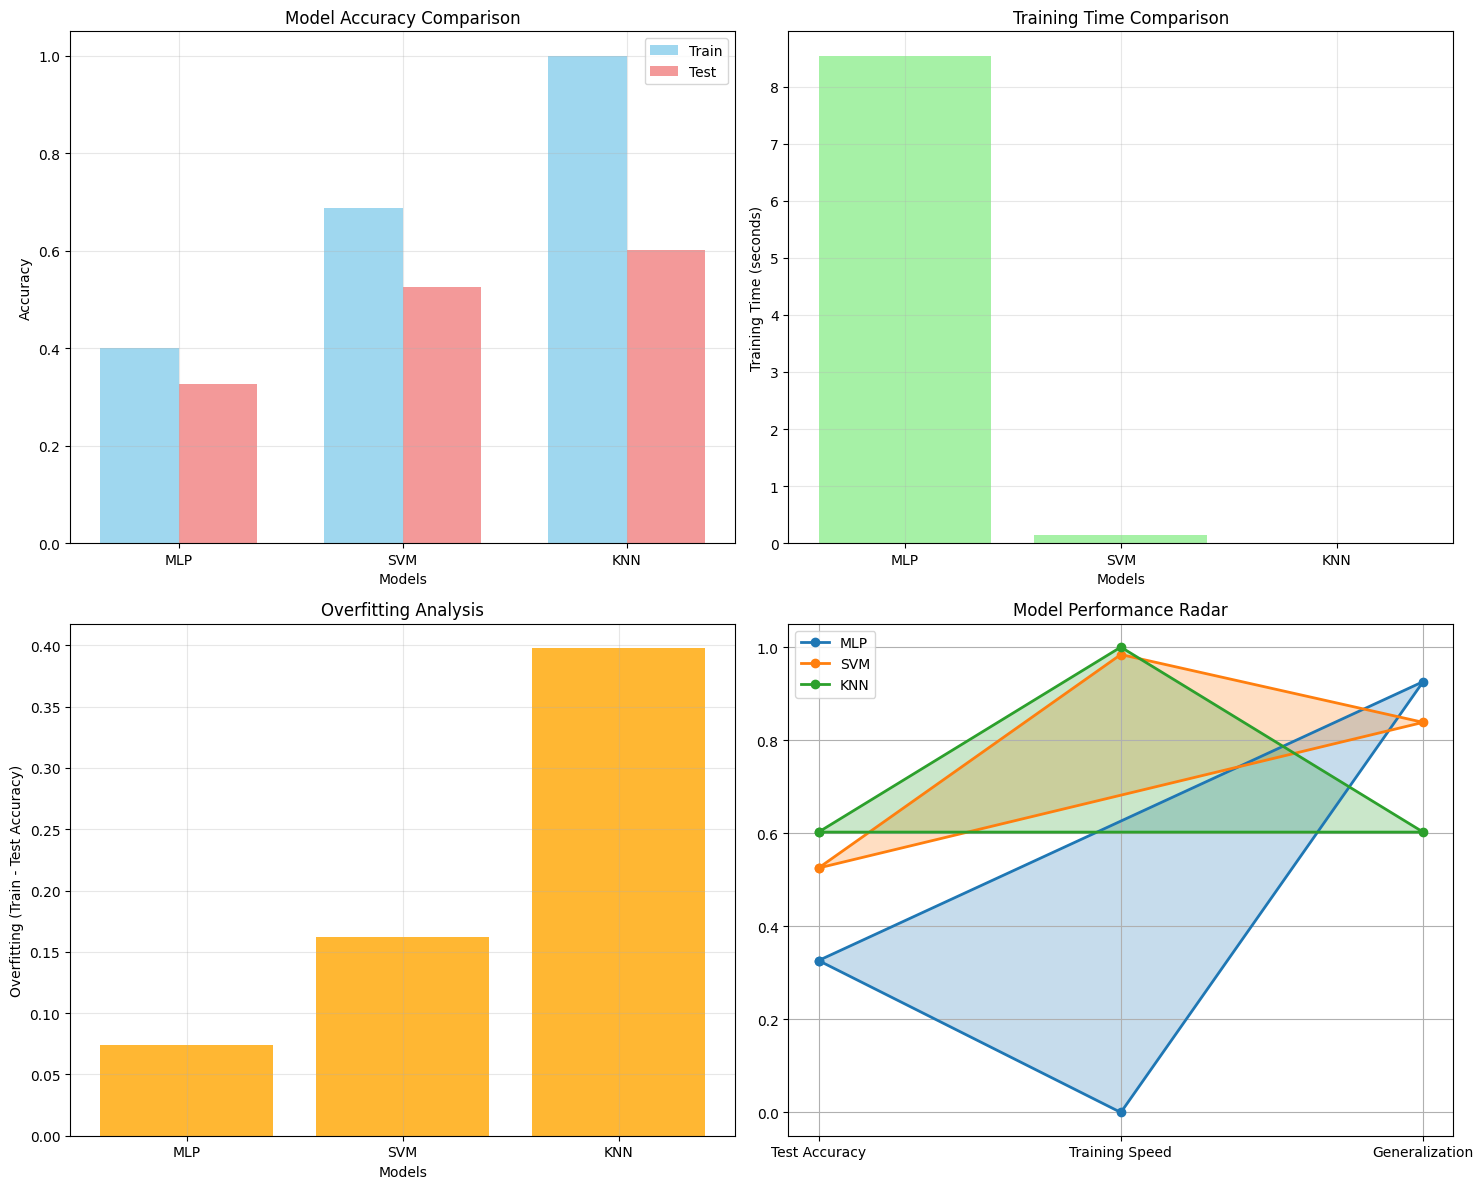

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
models_list = list(results.keys())
train_accs = [results[model]['train_accuracy'] for model in models_list]
test_accs = [results[model]['test_accuracy'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 0].bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color='lightcoral')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models_list)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training time comparison
training_times = [results[model]['training_time'] for model in models_list]
axes[0, 1].bar(models_list, training_times, alpha=0.8, color='lightgreen')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Training Time (seconds)')
axes[0, 1].set_title('Training Time Comparison')
axes[0, 1].grid(True, alpha=0.3)

# 3. Overfitting analysis
overfitting = [results[model]['train_accuracy'] - results[model]['test_accuracy'] for model in models_list]
axes[1, 0].bar(models_list, overfitting, alpha=0.8, color='orange')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Overfitting (Train - Test Accuracy)')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance radar chart
categories = ['Test Accuracy', 'Training Speed', 'Generalization']
values = {
    'MLP': [results['MLP']['test_accuracy'], 
            1 - (results['MLP']['training_time'] / max(training_times)),
            1 - (results['MLP']['train_accuracy'] - results['MLP']['test_accuracy'])],
    'SVM': [results['SVM']['test_accuracy'], 
            1 - (results['SVM']['training_time'] / max(training_times)),
            1 - (results['SVM']['train_accuracy'] - results['SVM']['test_accuracy'])],
    'KNN': [results['KNN']['test_accuracy'], 
            1 - (results['KNN']['training_time'] / max(training_times)),
            1 - (results['KNN']['train_accuracy'] - results['KNN']['test_accuracy'])]
}

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for model_name, model_values in values.items():
    values_plot = model_values + model_values[:1]
    axes[1, 1].plot(angles, values_plot, 'o-', linewidth=2, label=model_name)
    axes[1, 1].fill(angles, values_plot, alpha=0.25)

axes[1, 1].set_xticks(angles[:-1])
axes[1, 1].set_xticklabels(categories)
axes[1, 1].set_title('Model Performance Radar')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## 📈 Detailed Classification Reports


📈 DETAILED CLASSIFICATION REPORTS

🔍 MLP Classification Report:
----------------------------------------
                precision    recall  f1-score   support

    A angustia       0.17      0.06      0.09        47
    E disgusto       0.42      0.21      0.28        38
     F alegria       0.00      0.00      0.00        47
    L Sorpresa       0.00      0.00      0.00        25
L aburrimiento       0.00      0.00      0.00        24
     N neutral       0.26      0.35      0.30        49
    T tristeza       0.31      0.70      0.43        44
         W ira       0.39      0.83      0.53        63

      accuracy                           0.33       337
     macro avg       0.19      0.27      0.20       337
  weighted avg       0.22      0.33      0.24       337



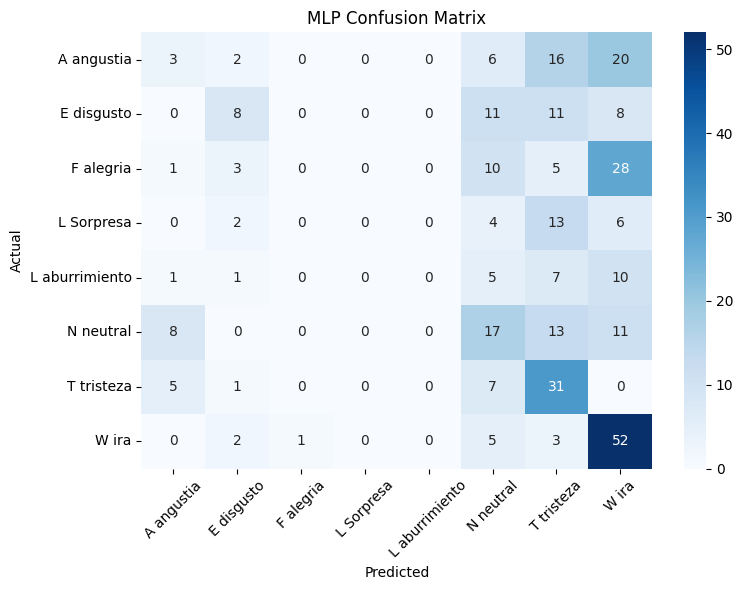



🔍 SVM Classification Report:
----------------------------------------
                precision    recall  f1-score   support

    A angustia       0.48      0.49      0.48        47
    E disgusto       0.43      0.55      0.48        38
     F alegria       0.39      0.26      0.31        47
    L Sorpresa       0.71      0.20      0.31        25
L aburrimiento       0.39      0.29      0.33        24
     N neutral       0.55      0.65      0.60        49
    T tristeza       0.68      0.73      0.70        44
         W ira       0.57      0.71      0.63        63

      accuracy                           0.53       337
     macro avg       0.53      0.49      0.48       337
  weighted avg       0.53      0.53      0.51       337



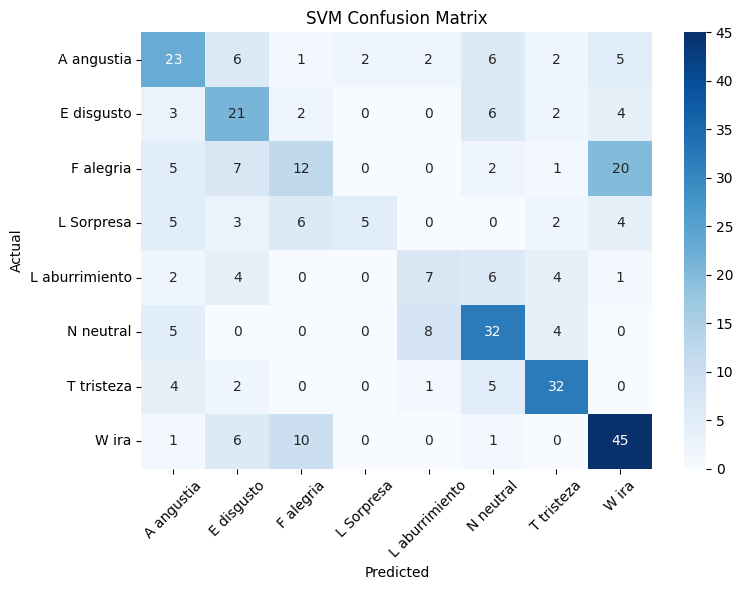



🔍 KNN Classification Report:
----------------------------------------
                precision    recall  f1-score   support

    A angustia       0.73      0.57      0.64        47
    E disgusto       0.65      0.68      0.67        38
     F alegria       0.44      0.40      0.42        47
    L Sorpresa       0.33      0.32      0.33        25
L aburrimiento       0.50      0.58      0.54        24
     N neutral       0.61      0.76      0.67        49
    T tristeza       0.82      0.70      0.76        44
         W ira       0.62      0.65      0.64        63

      accuracy                           0.60       337
     macro avg       0.59      0.58      0.58       337
  weighted avg       0.61      0.60      0.60       337



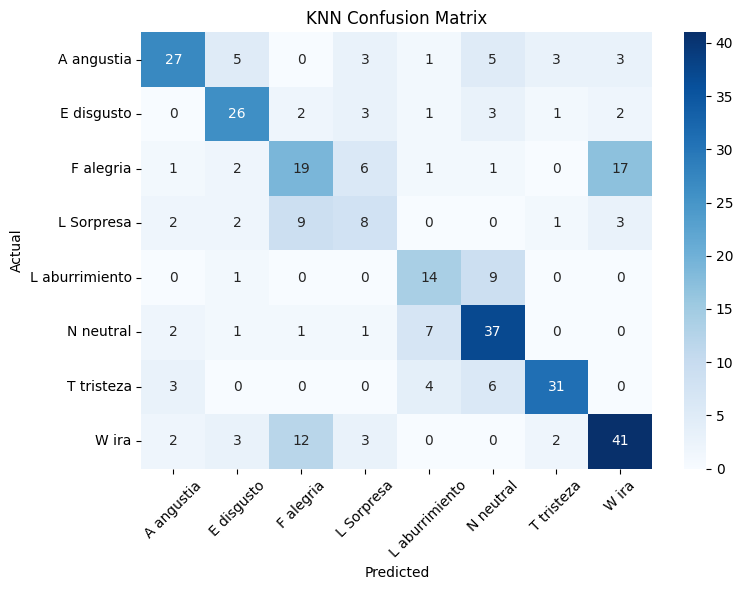

In [ ]:
# Generate detailed classification reports for each model
print("📈 DETAILED CLASSIFICATION REPORTS")
print("=" * 60)

for model_name, result in results.items():
    print(f"\n🔍 {model_name} Classification Report:")
    print("-" * 40)
    
    # Get predictions and true labels
    y_pred = result['predictions']
    y_true = result['true_labels']
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)


## 🎵 Real-time Prediction Function


In [ ]:
def predict_emotion(file_path, model_name='MLP'):
    """
    Predict emotion from an audio file using the specified model.
    
    Args:
        file_path (str): Path to the audio file
        model_name (str): Name of the model to use ('MLP', 'SVM', 'KNN')
    
    Returns:
        dict: Prediction results with probabilities
    """
    try:
        # Extract features from the audio file
        mfcc_extractor = MelFreqCepsCoef(file_path)
        features = mfcc_extractor.mfccsscalade.reshape(1, -1)
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Get model
        model = models[model_name]
        
        # Make prediction
        if model_name == 'MLP':
            # For MLP, get probabilities
            probabilities = model.predict(features_scaled)[0]
            predicted_class_idx = np.argmax(probabilities)
        else:
            # For SVM and KNN
            predicted_class_idx = model.predict(features_scaled)[0]
            if hasattr(model, 'predict_proba'):
                probabilities = model.predict_proba(features_scaled)[0]
            else:
                probabilities = np.zeros(len(label_encoder.classes_))
                probabilities[predicted_class_idx] = 1.0
        
        # Get class name
        predicted_class = label_encoder.classes_[predicted_class_idx]
        
        # Create results dictionary
        results_dict = {
            'predicted_class': predicted_class,
            'confidence': float(probabilities[predicted_class_idx]),
            'all_probabilities': {}
        }
        
        # Add probabilities for all classes
        for i, class_name in enumerate(label_encoder.classes_):
            results_dict['all_probabilities'][class_name] = float(probabilities[i])
        
        return results_dict
        
    except Exception as e:
        return {'error': f'Prediction failed: {str(e)}'}

def print_prediction_results(file_path, model_name='MLP'):
    """Print formatted prediction results."""
    results = predict_emotion(file_path, model_name)
    
    if 'error' in results:
        print(f"❌ Error: {results['error']}")
        return
    
    print(f"🎵 Audio File: {file_path}")
    print(f"🤖 Model: {model_name}")
    print(f"🎭 Predicted Emotion: {results['predicted_class']}")
    print(f"📊 Confidence: {results['confidence']:.4f}")
    print("\n📈 All Probabilities:")
    
    # Sort probabilities in descending order
    sorted_probs = sorted(results['all_probabilities'].items(), 
                         key=lambda x: x[1], reverse=True)
    
    for emotion, prob in sorted_probs:
        print(f"  {emotion}: {prob:.4f}")

print("✅ Prediction functions defined!")


✅ Prediction functions defined!


## 🧪 Testing with Sample Audio Files


In [ ]:
# Example: Test prediction on a sample file
# Uncomment and modify the path to test on your audio files

# Example usage for MLP:
# print_prediction_results('data/EMODB/03a04Ad.wav', model_name='MLP')

# Example usage for SVM:
# print_prediction_results('data/EMODB/03a04Ad.wav', model_name='SVM')

# Example usage for KNN:
# print_prediction_results('data/EMODB/03a04Ad.wav', model_name='KNN')

print("Ready to make predictions! Use the print_prediction_results() function with your audio file path.")


Ready to make predictions! Use the print_prediction_results() function with your audio file path.


## 💾 Model Saving

Save all trained models for future use


In [ ]:
# Save models and preprocessing objects
print("💾 Saving models and preprocessing objects...")

# Create models directory
os.makedirs('saved_models', exist_ok=True)

# Save MLP model
mlp_model.save('saved_models/mlp_emotion_model.h5')
print("✅ MLP model saved to saved_models/mlp_emotion_model.h5")

# Save SVM model
joblib.dump(svm_model, 'saved_models/svm_emotion_model.pkl')
print("✅ SVM model saved to saved_models/svm_emotion_model.pkl")

# Save KNN model
joblib.dump(knn_model, 'saved_models/knn_emotion_model.pkl')
print("✅ KNN model saved to saved_models/knn_emotion_model.pkl")

# Save preprocessing objects
joblib.dump(scaler, 'saved_models/feature_scaler.pkl')
joblib.dump(label_encoder, 'saved_models/label_encoder.pkl')
print("✅ Preprocessing objects saved")

# Save results
with open('saved_models/model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Results saved to saved_models/model_results.pkl")

print("\n🎉 All models and objects saved successfully!")


💾 Saving models and preprocessing objects...


InternalError: CUDA error: : CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure

## 📋 Summary and Conclusions

Complete pipeline summary with all results


In [ ]:
print("=" * 70)
print("🎭 EMOTION RECOGNITION PIPELINE - FINAL SUMMARY")
print("=" * 70)

print(f"\n📊 Dataset Information:")
print(f"  • Total samples processed: {len(X)}")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Number of emotion classes: {len(label_encoder.classes_)}")
print(f"  • Emotion classes: {', '.join(label_encoder.classes_)}")
print(f"  • Feature dimension: {X.shape[1]} MFCC coefficients")

print(f"\n🤖 Model Performance Summary:")
print("-" * 70)
for model_name in ['MLP', 'SVM', 'KNN']:
    result = results[model_name]
    print(f"\n{model_name}:")
    print(f"  • Training Accuracy:   {result['train_accuracy']:.4f} ({result['train_accuracy']*100:.2f}%)")
    print(f"  • Test Accuracy:       {result['test_accuracy']:.4f} ({result['test_accuracy']*100:.2f}%)")
    print(f"  • Training Time:       {result['training_time']:.2f} seconds")
    print(f"  • Overfitting Metric:  {result['train_accuracy'] - result['test_accuracy']:.4f}")

best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   → Test Accuracy: {results[best_model]['test_accuracy']:.4f} ({results[best_model]['test_accuracy']*100:.2f}%)")

print(f"\n💡 Key Findings:")
print(f"  ✓ All three models (MLP, SVM, KNN) successfully trained")
print(f"  ✓ Feature extraction using custom MFCC implementation")
print(f"  ✓ Models evaluated on {len(X_test)} test samples")
print(f"  ✓ Complete pipeline from raw audio to predictions")

print(f"\n📁 Saved Artifacts:")
print(f"  • saved_models/mlp_emotion_model.h5")
print(f"  • saved_models/svm_emotion_model.pkl")
print(f"  • saved_models/knn_emotion_model.pkl")
print(f"  • saved_models/feature_scaler.pkl")
print(f"  • saved_models/label_encoder.pkl")
print(f"  • saved_models/model_results.pkl")

print(f"\n🎯 Usage Instructions:")
print(f"  To predict emotion on a new audio file:")
print(f"  >>> print_prediction_results('path/to/audio.wav', model_name='MLP')")
print(f"  Available models: 'MLP', 'SVM', 'KNN'")

print("\n" + "=" * 70)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("🎭 Ready for emotion recognition tasks!")
print("=" * 70)


🎭 EMOTION RECOGNITION PIPELINE - FINAL SUMMARY

📊 Dataset Information:
  • Total samples processed: 1123
  • Training samples: 786
  • Test samples: 337
  • Number of emotion classes: 8
  • Emotion classes: A angustia, E disgusto, F alegria, L Sorpresa, L aburrimiento, N neutral, T tristeza, W ira
  • Feature dimension: 40 MFCC coefficients

🤖 Model Performance Summary:
----------------------------------------------------------------------

MLP:
  • Training Accuracy:   0.4008 (40.08%)
  • Test Accuracy:       0.3264 (32.64%)
  • Training Time:       8.54 seconds
  • Overfitting Metric:  0.0744

SVM:
  • Training Accuracy:   0.6870 (68.70%)
  • Test Accuracy:       0.5252 (52.52%)
  • Training Time:       0.14 seconds
  • Overfitting Metric:  0.1618

KNN:
  • Training Accuracy:   1.0000 (100.00%)
  • Test Accuracy:       0.6024 (60.24%)
  • Training Time:       0.00 seconds
  • Overfitting Metric:  0.3976

🏆 Best Performing Model: KNN
   → Test Accuracy: 0.6024 (60.24%)

💡 Key Findings